## 使用VAE來做手寫辨識，將最後的結果動態呈現出來，打造最好的呈現方式!
想想在encoder找到兩張手寫數字 a, b 的 latent representation，  
然後從代表 a 的 latent 到代表 b 的 latent 拉一直線，  
把線段中代表的圖用 decoder 畫出來，這個必須是動態的圖片變化，可參考上禮拜上課呈現出來中間那張圖的樣子

*模型權重可使用澤佑助教提供的

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

/home/brianlin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 讀MNIST資料並且攤平

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

11493376/11490434 [==============================] - 3s 0us/step


### VAE

In [16]:
enc_1 = Dense(100, activation = 'sigmoid')
enc_2 = Dense(10, activation = 'sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [17]:
x = Input(shape=(784,))
enc_x = enc_1(x)
enc_x = enc_2(enc_x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

定義抽樣函數

In [18]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [19]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [20]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [21]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 100)          78500       input_4[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 10)           1010        dense_19[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 2)            22          dense_20[0][0]                   
__________________________________________________________________________________________________
dense_22 (

### Loss 函數的建立

In [22]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [23]:
VAE.compile(loss = vae_loss, optimizer = Adam())

In [24]:
VAE.fit(x_train, x_train, batch_size=32, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 10s 169us/step - loss: 201.0330
Epoch 2/10
60000/60000 [==============================] - 9s 148us/step - loss: 181.5708
Epoch 3/10
60000/60000 [==============================] - 9s 150us/step - loss: 178.6752
Epoch 4/10
60000/60000 [==============================] - 9s 153us/step - loss: 175.1551
Epoch 5/10
60000/60000 [==============================] - 9s 151us/step - loss: 171.2364
Epoch 6/10
60000/60000 [==============================] - 9s 151us/step - loss: 168.2349
Epoch 7/10
60000/60000 [==============================] - 9s 152us/step - loss: 166.1493
Epoch 8/10
60000/60000 [==============================] - 9s 150us/step - loss: 164.4684
Epoch 9/10
60000/60000 [==============================] - 9s 145us/step - loss: 163.0993
Epoch 10/10
60000/60000 [==============================] - 9s 147us/step - loss: 161.9113


### 視覺化呈現

In [25]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 22        
Total params: 79,532
Trainable params: 79,532
Non-trainable params: 0
_________________________________________________________________


In [27]:
h_input = Input(shape = (2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_24 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [28]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 1922 圖的 latent 表示為 [[1.0844735 0.5749737]]


In [31]:
indices = np.random.randint(x_test.shape[0], size = 1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

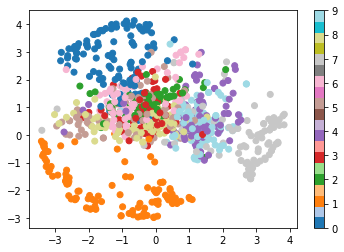

In [32]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c = y_test0[indices], cmap = 'tab20')
plt.colorbar()
plt.show()

In [33]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [34]:
n =15
digit_size = 28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

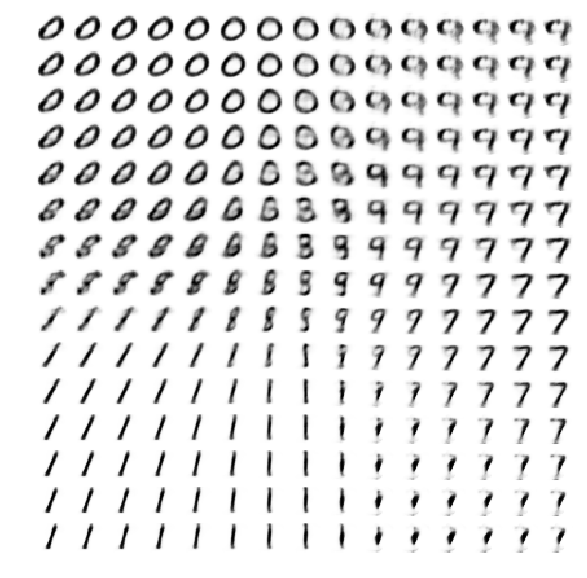

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

### 動態比較

In [36]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1 - t) * x_train0[idx_1] + t * x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1 + 1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2 + 1]).squeeze()
    mu_t = (1-t) * mu_0 + t * mu_1

    plt.figure(figsize = (10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap = 'Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap = 'Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap = 'Greys')

In [37]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size = 2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]


In [38]:
interact(inBetween, t=FloatSlider(value = 0.5, 
                                  min = 0, 
                                  max = 1.0,
                                  step = 0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('widget-interact',))

<function __main__.inBetween>